In [1]:
# Import python packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
#import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Load imputed Houston data
df_sf = pd.read_pickle("san_francisco_df.pkl")




In [3]:
print(df_sf)

df_sf_raw = df_sf.copy()

                  cuisine product_type     revenue       cost   cases  \
1520                Asian     Non Food    96654.70   73136.02  2379.0   
1521                Asian     Non Food    95885.09   72396.51  2280.0   
1522                Asian     Non Food   102336.70   70042.78  2262.0   
1523                Asian     Non Food    94091.86   79140.94  2106.0   
1524                Asian     Non Food    96427.78   77524.74  2298.0   
...                   ...          ...         ...        ...     ...   
3035  Mainstream American     Proteins   961627.04  763730.61  8074.0   
3036  Mainstream American     Proteins   987648.76  802877.69  9314.0   
3037  Mainstream American     Proteins   914742.09  814877.83  9534.0   
3038  Mainstream American     Proteins  1024718.02  916896.40  8713.0   
3039  Mainstream American     Proteins   954493.70  775897.90  8776.0   

      customer_count           city       week  
1520           104.0  SAN FRANCISCO 2020-06-29  
1521           104.0  SAN

In [4]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variable representing the time steps
x=np.array(range(len(df_sf))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, df_sf['revenue'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
df_sf['Linear model']=predictions

# calculate the root mean squared error
rmse=sqrt(mean_squared_error(df_sf['revenue'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 212341.5


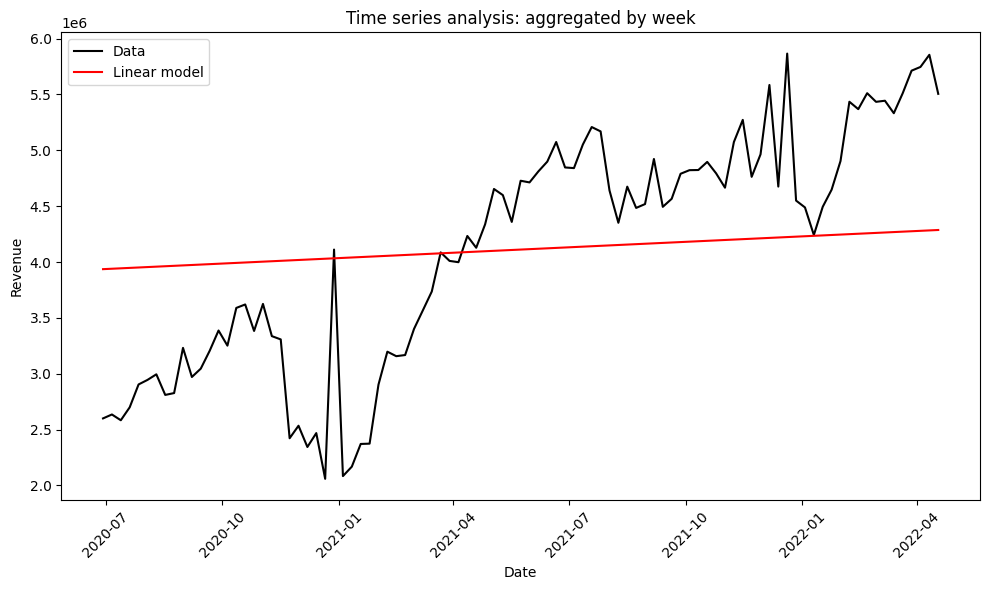

In [6]:


#nsure 'week' is datetime
df_sf['week'] = pd.to_datetime(df_sf['week'])

#Aggregate revenue and linear model by week
df_weekly = df_sf.groupby('week', as_index=False)[['revenue', 'Linear model']].sum()


plt.figure(figsize=(10, 6))
plt.plot(df_weekly['week'], df_weekly['revenue'], label='Data', color='black')
plt.plot(df_weekly['week'], df_weekly['Linear model'], label='Linear model', color='red')

plt.title('Time series analysis: aggregated by week')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
weekly_revenue = df_sf.groupby('week')['revenue'].sum().asfreq('W-MON')

In [8]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(df_sf['revenue'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.141


Not stationary- will difference

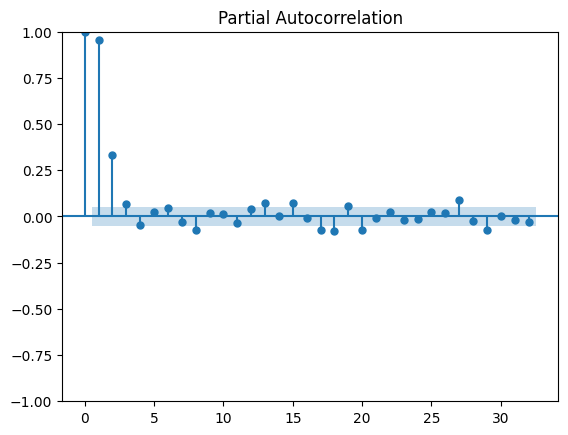

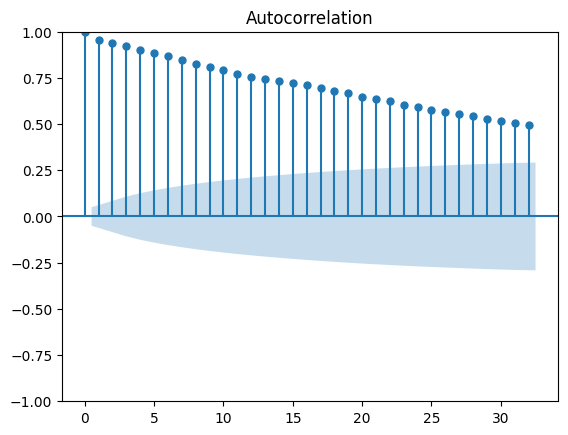

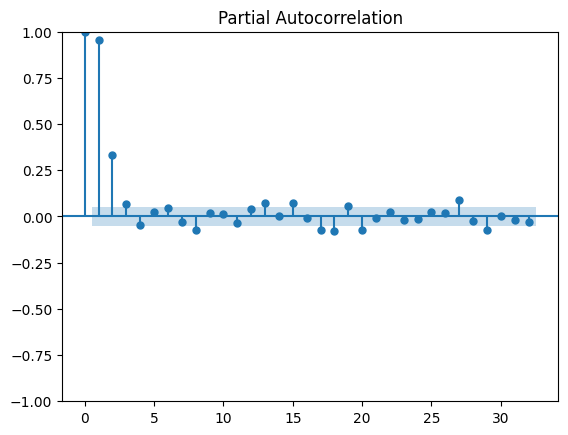

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_sf['revenue'])
plot_pacf(df_sf['revenue'])

In [11]:
df_sf['log_revenue'] = np.log(df_sf['revenue'])


In [12]:
import statsmodels.api as sm

order = (0, 1, 1)
seasonal_order = (0, 1, 1, 12)

model = sm.tsa.SARIMAX(df_sf['log_revenue'], order=order, seasonal_order=seasonal_order).fit()

print(model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        log_revenue   No. Observations:                 1520
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -248.898
Date:                            Sun, 15 Jun 2025   AIC                            503.795
Time:                                    22:25:51   BIC                            519.749
Sample:                                         0   HQIC                           509.737
                                           - 1520                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3531      0.008    -45.708      0.000      -0.368      -0.338
ma.S.L12      -0.9996      0.487   

The model captures both short-term and seasonal effects well.
All coefficients are statistically significant.
Residuals are not normally distributed and very heavy-tailed, likely due to outliers or spikes in log revenue.
Despite non-normality, residuals are not autocorrelated, and variance is stable — so the model is likely still usable for forecasting.

In [13]:
weekly_revenue_diff = weekly_revenue.diff().dropna()

In [14]:
# Fit model on differenced data
model = ARIMA(weekly_revenue_diff, order=(1, 1, 1))  
fitted = model.fit()

# Forecast differenced values
forecast_diff = fitted.forecast(steps=12)

# Recover original forecasted revenue values by cumulatively summing 
# and adding the last known actual value before differencing
last_actual = df_sf['revenue'].iloc[-1]
forecast_revenue = forecast_diff.cumsum() + last_actual

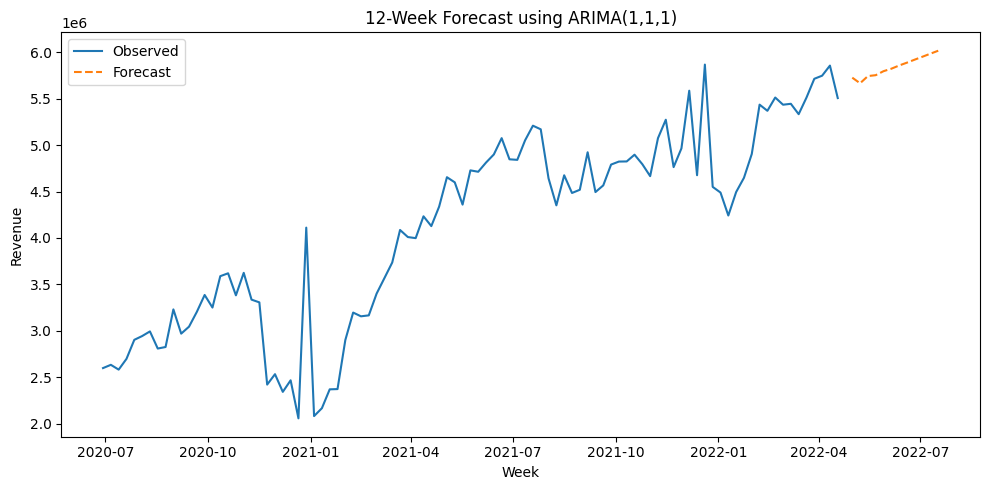

In [17]:
# Reintegrate (undo differencing)
last_observed = weekly_revenue.iloc[-1]
forecast = forecast_diff.cumsum() + last_observed

# Plot
plt.figure(figsize=(10, 5))
plt.plot(weekly_revenue.index, weekly_revenue, label='Observed')
plt.plot(pd.date_range(weekly_revenue.index[-1], periods=13, freq='W')[1:], forecast, label='Forecast', linestyle='--')
plt.title("12-Week Forecast using ARIMA(1,1,1)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
for p in range(0, 4):
    for d in range(1, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(df['revenue'], order=(p, d, q))
                results = model.fit()
                print(f'ARIMA({p},{d},{q}) AIC: {results.aic}')
            except:
                continue

In [19]:
ts = df_sf['revenue']  # or weekly_revenue, etc.

In [20]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(1, 3):  
        for q in range(0, 4):
            try:
                model = ARIMA(ts, order=(p, d, q))
                result = model.fit()
                aic = result.aic
                print(f'ARIMA({p},{d},{q}) AIC: {aic:.2f}')
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = result
            except:
                continue

print(f'\n✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')

ARIMA(0,1,0) AIC: 38167.19
ARIMA(0,1,1) AIC: 37930.08
ARIMA(0,1,2) AIC: 37920.93
ARIMA(0,1,3) AIC: 37922.24
ARIMA(0,2,0) AIC: 39686.17
ARIMA(0,2,1) AIC: 38199.97
ARIMA(0,2,2) AIC: 37954.30
ARIMA(0,2,3) AIC: 37925.05
ARIMA(1,1,0) AIC: 37929.53
ARIMA(1,1,1) AIC: 37921.18
ARIMA(1,1,2) AIC: 37922.64
ARIMA(1,1,3) AIC: 37923.04
ARIMA(1,2,0) AIC: 38807.77
ARIMA(1,2,1) AIC: 37915.15
ARIMA(1,2,2) AIC: 37935.45
ARIMA(1,2,3) AIC: 37933.77
ARIMA(2,1,0) AIC: 37919.46
ARIMA(2,1,1) AIC: 37919.40
ARIMA(2,1,2) AIC: 37921.18
ARIMA(2,1,3) AIC: 37907.39
ARIMA(2,2,0) AIC: 38430.20
ARIMA(2,2,1) AIC: 37958.43
ARIMA(2,2,2) AIC: 37928.17
ARIMA(2,2,3) AIC: 37916.26
ARIMA(3,1,0) AIC: 37919.81
ARIMA(3,1,1) AIC: 37921.30
ARIMA(3,1,2) AIC: 37915.54
ARIMA(3,1,3) AIC: 37909.40
ARIMA(3,2,0) AIC: 38316.78
ARIMA(3,2,1) AIC: 37959.12
ARIMA(3,2,2) AIC: 37920.89
ARIMA(3,2,3) AIC: 37904.66

✅ Best ARIMA order: (3, 2, 3) with AIC: 37904.66


In [21]:
best_order = (3, 2, 3)

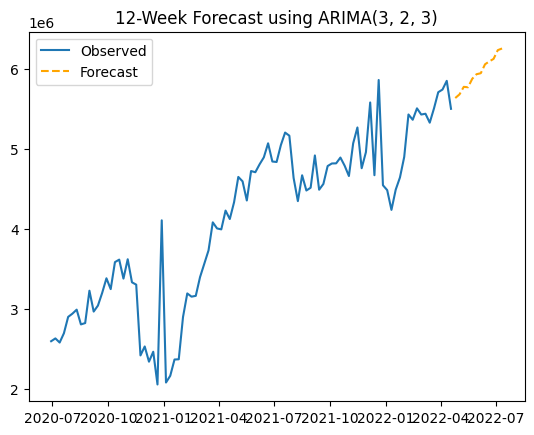

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(weekly_revenue, order=best_order)
fitted = model.fit()

forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using ARIMA{best_order}")
plt.legend()
plt.show()

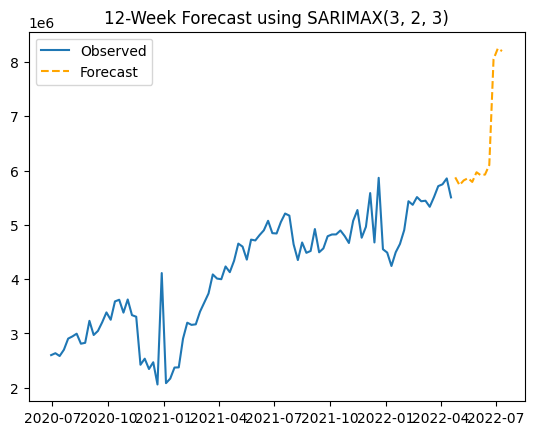

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(weekly_revenue, order=(3, 2, 3), seasonal_order=(1, 1, 1, 52))
fitted = model.fit()
forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using SARIMAX{best_order}")
plt.legend()
plt.show()

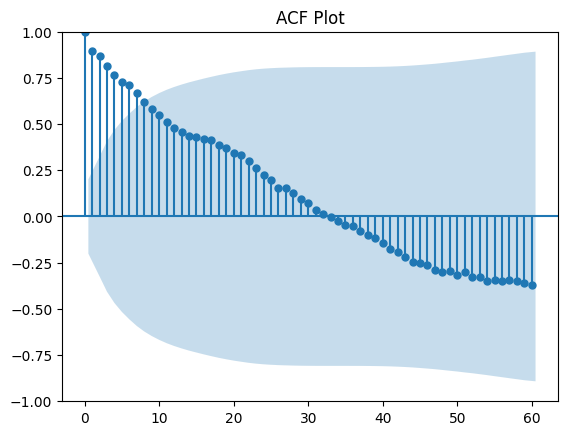

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(weekly_revenue, lags=60)
plt.title("ACF Plot")
plt.show()

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_candidates = [1, 4, 13, 26, 52]
aic_scores = []

for s in seasonal_candidates:
    try:
        model = SARIMAX(weekly_revenue, order=(1, 1, 1), seasonal_order=(1, 1, 1, s))
        fit = model.fit(disp=False)
        aic_scores.append((s, fit.aic))
    except:
        continue

aic_scores.sort(key=lambda x: x[1])
print("Best seasonal period by AIC:", aic_scores[0])

Best seasonal period by AIC: (52, np.float64(1214.8154576437369))


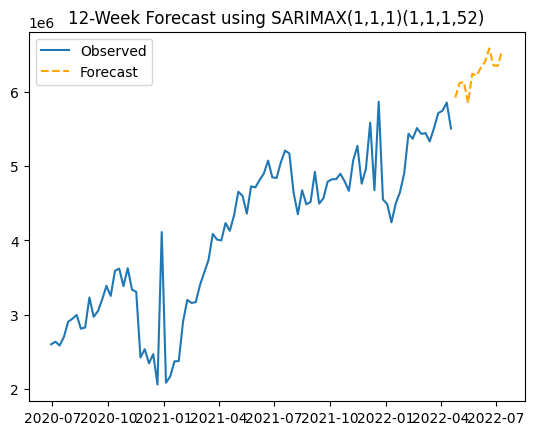

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(1, 1, 1),                
    seasonal_order=(1, 1, 1, 52),   
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMAX(1,1,1)(1,1,1,52)")
plt.legend()
plt.show()

In [27]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], 1, x[2], 52) for x in pdq]

lowest_aic = float("inf")
best_config = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                weekly_revenue,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_config = (param, param_seasonal)
        except:
            continue

print("Best SARIMA config:", best_config)
print("Lowest AIC:", lowest_aic)

Best SARIMA config: ((0, 1, 0), (0, 1, 1, 52))
Lowest AIC: 4.0


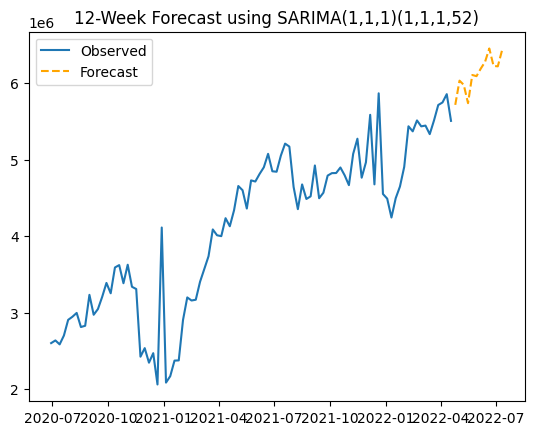

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(0, 1, 0),                # Simpler ARIMA
    seasonal_order=(0, 1, 1, 52),   # Annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMA(1,1,1)(1,1,1,52)")
plt.legend()
plt.show()

In [29]:
forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean

print("12-Week Forecast Values:")
print(forecast_values)

12-Week Forecast Values:
2022-04-25    5714672.29
2022-05-02    6031244.36
2022-05-09    5976203.68
2022-05-16    5736512.62
2022-05-23    6104954.06
2022-05-30    6090010.79
2022-06-06    6188923.23
2022-06-13    6276099.99
2022-06-20    6451687.49
2022-06-27    6223995.79
2022-07-04    6218040.36
2022-07-11    6428458.66
Freq: W-MON, Name: predicted_mean, dtype: float64


In [30]:

forecast_df = forecast.predicted_mean.to_frame(name="forecast")

forecast_df.to_pickle("SF_forecast_12_weeks.pkl")
forecast_df.to_csv("SF_forecast_12_weeks.csv")


Going to do some test/train split and run with this model

In [31]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon= 12

# Set a model order, i.e. how many past data points should be used as input for prediction
model_order=100

In [32]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(df_sf) - testing_dataset_size

# Get the training and testing sets
training_data=df_sf[:training_set_size]
testing_data=df_sf[training_set_size:]

In [35]:
# Ensure 'week' is datetime
df_sf['week'] = pd.to_datetime(df_sf['week'])

# Group by week + city, sum revenue and other relevant columns
df_sf_agg = df_sf.groupby(['week', 'city'], as_index=False).agg({
    'revenue': 'sum',
    'cost': 'sum',
    'cases': 'sum',
    'customer_count': 'sum'
})

# Optional: Just filter for one city (if modeling per-city)
df_sf_city = df_sf_agg[df_sf_agg['city'] == 'HOUSTON'].copy()

# Set week as index and sort
df_sf_city = df_sf_city.sort_values('week')
df_sf_city.set_index('week', inplace=True)

# Add log transform
df_sf_city['log_revenue'] = np.log(df_sf_city['revenue'])

Datetime index type: <class 'pandas.core.indexes.base.Index'>
First few rows:      cuisine product_type    revenue      cost   cases  customer_count  \
1520   Asian     Non Food   96654.70  73136.02  2379.0           104.0   
1521   Asian     Non Food   95885.09  72396.51  2280.0           104.0   
1522   Asian     Non Food  102336.70  70042.78  2262.0           110.0   
1523   Asian     Non Food   94091.86  79140.94  2106.0           108.0   
1524   Asian     Non Food   96427.78  77524.74  2298.0           101.0   

               city       week  Linear model  log_revenue  
1520  SAN FRANCISCO 2020-06-29  79972.468136    11.478900  
1521  SAN FRANCISCO 2020-07-06  80205.510377    11.470906  
1522  SAN FRANCISCO 2020-07-13  80438.552619    11.536024  
1523  SAN FRANCISCO 2020-07-20  80671.594860    11.452027  
1524  SAN FRANCISCO 2020-07-27  80904.637102    11.476550  


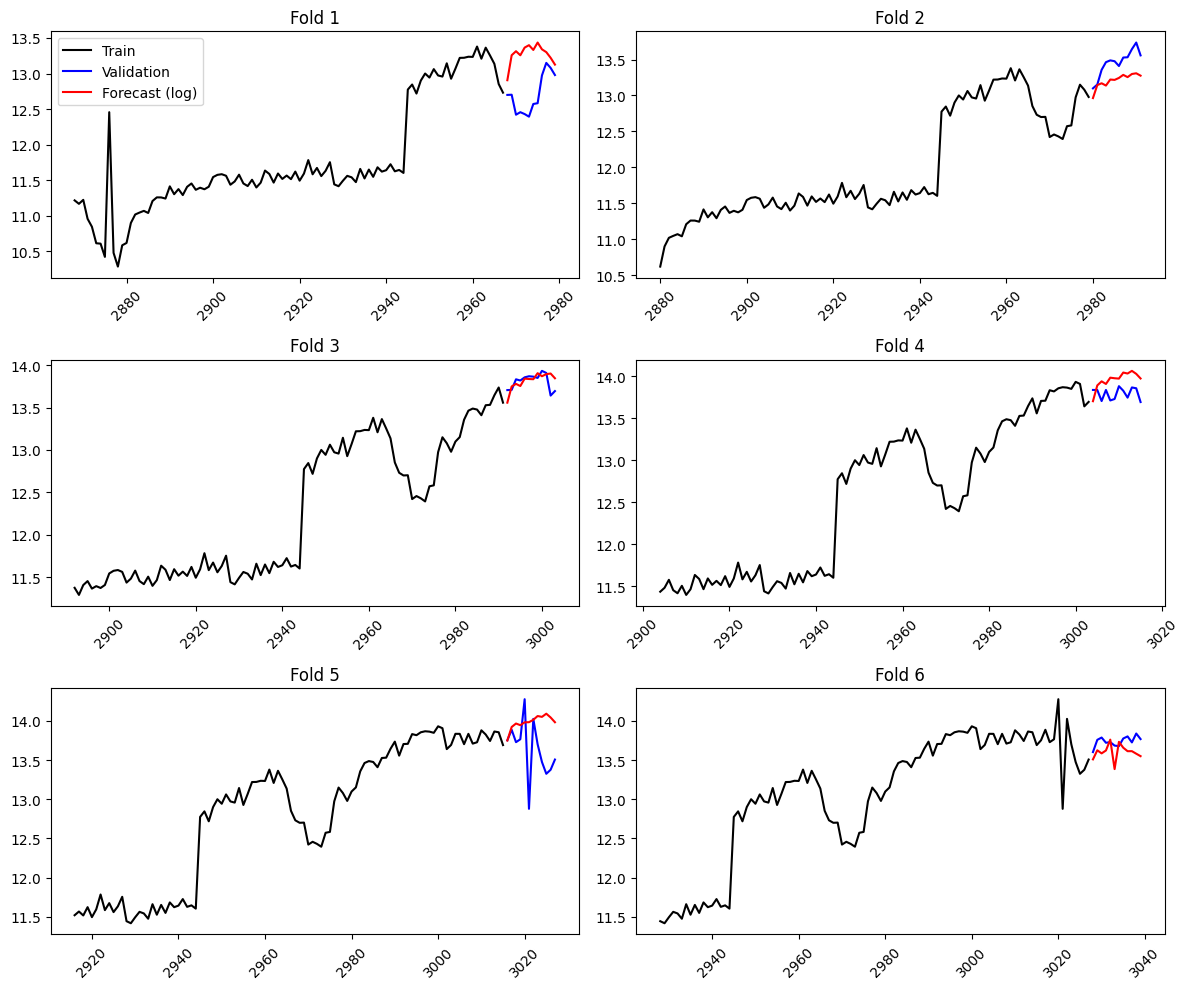


Average RMSE across folds (original revenue scale): 227,717.36


In [37]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Just sort by the index since 'week' is already set as index
df_sf = df_sf.sort_index()

# Optional sanity check
print("Datetime index type:", type(df_sf.index))
print("First few rows:", df_sf.head())

# Parameters
folds = 6
forecast_horizon = 12
model_order = 100  # min training size for SARIMA to stabilize

# Holders
validation_rmse_values = []
predicted_values = []
validation_values = []

# Set up plots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Cross-validation loop
for i, (train_idx, val_idx) in enumerate(tscv.split(df_sf)):

    train = df_sf.iloc[train_idx]
    val = df_sf.iloc[val_idx]

    # Fit model
    model = SARIMAX(train['log_revenue'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.forecast(steps=len(val))

    # Back-transform
    forecast_exp = np.exp(forecast)
    actual_exp = np.exp(val['log_revenue'])

    # Save for global RMSE later
    predicted_values.extend(forecast_exp)
    validation_values.extend(actual_exp)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(actual_exp, forecast_exp))
    validation_rmse_values.append(rmse)

    # Plot
    axs[i].plot(train.index, train['log_revenue'], label='Train', color='black')
    axs[i].plot(val.index, val['log_revenue'], label='Validation', color='blue')
    axs[i].plot(val.index, forecast, label='Forecast (log)', color='red')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].tick_params(axis='x', labelrotation=45)

    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()

# Final RMSE summary
if validation_rmse_values:
    print(f"\nAverage RMSE across folds (original revenue scale): {np.mean(validation_rmse_values):,.2f}")
else:
    print("\nNo valid RMSE values calculated.")